## Import

In [17]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box
import pandas as pd

## Map loading and merging

In [4]:
# Load the GeoPackage file (adjust layer name if needed)
gpkg_path = "carte 1970 parties 2 et 6.gpkg"

gdf = gpd.read_file(gpkg_path)

# Save to GeoJSON
geojson_path = "roads_2_6_1975.geojson"
gdf.to_file(geojson_path, driver="GeoJSON")

print(f"GeoJSON file saved at: {geojson_path}")

GeoJSON file saved at: roads_2_6_1975.geojson


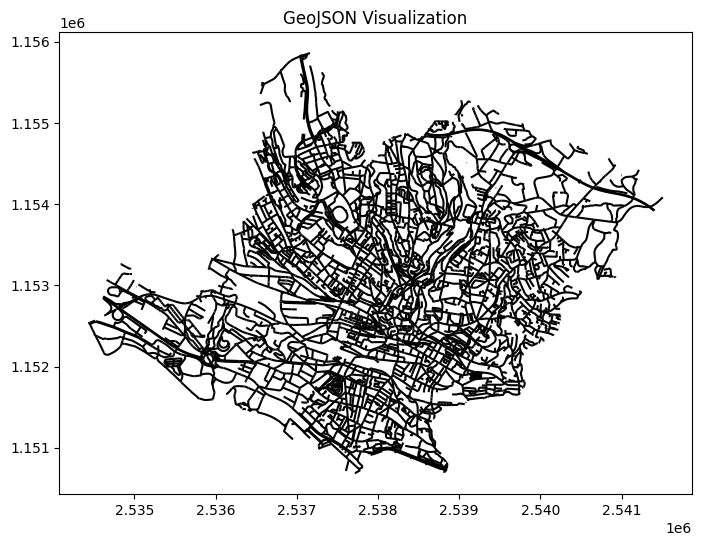

In [9]:
# Load GeoJSON
geojson_path = "roads_1_4_1975.geojson"
gdf_1_4 = gpd.read_file(geojson_path)

# Plot the GeoJSON file
gdf_1_4.plot(figsize=(10, 6), edgecolor="black", cmap="viridis")
plt.title("GeoJSON Visualization")
plt.show()

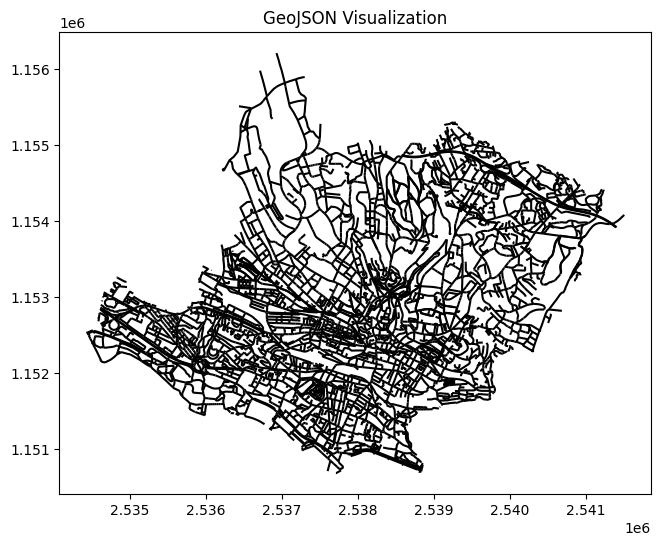

In [19]:
# Load GeoJSON
geojson_path = "roads_2_6_1975.geojson"
gdf_2_6 = gpd.read_file(geojson_path)

# Plot the GeoJSON file
gdf_2_6.plot(figsize=(10, 6), edgecolor="black", cmap="viridis")
plt.title("GeoJSON Visualization")
plt.show()

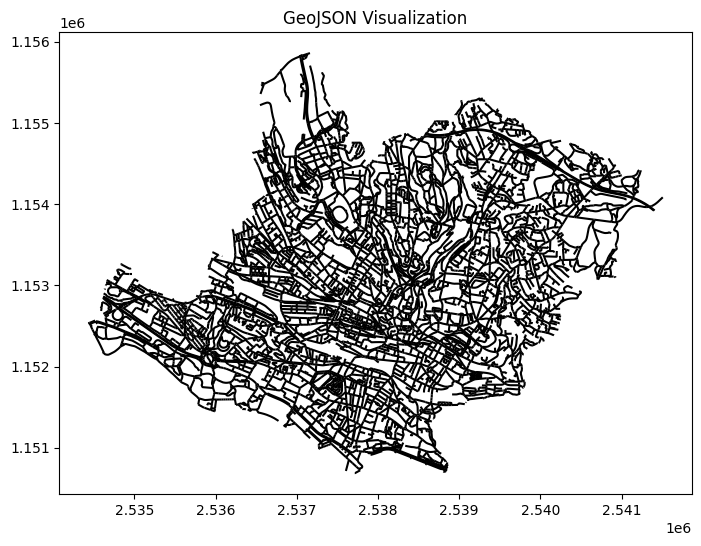

In [11]:
# Load GeoJSON
geojson_path = "roads_2025_parties.geojson"
gdf = gpd.read_file(geojson_path)

# Plot the GeoJSON file
gdf.plot(figsize=(10, 6), edgecolor="black", cmap="viridis")
plt.title("GeoJSON Visualization")
plt.show()

In [36]:
combined_roads = pd.concat([gdf_2_6[gdf_2_6.PARTIE == 2],gdf_2_6[gdf_2_6.PARTIE == 6],gdf_1_4[gdf_1_4.PARTIE == 4],gdf_1_4[gdf_1_4.PARTIE == 1],gdf[gdf.PARTIE == 3],gdf[gdf.PARTIE == 5]],axis=0)

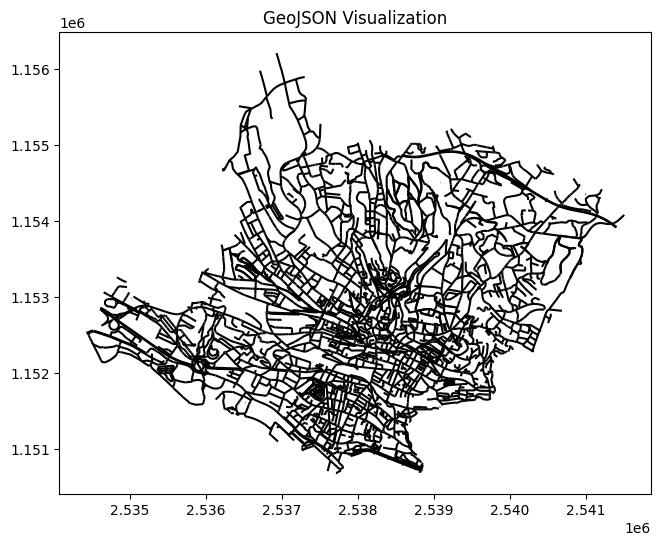

In [37]:
# Plot the GeoJSON file
combined_roads.plot(figsize=(10, 6), edgecolor="black", cmap="viridis")
plt.title("GeoJSON Visualization")
plt.show()

## Functions and first example

In [18]:
MEAN_WIDTH = 3.418189974206572
MAX_WIDTH = 8

# Load GeoJSON with roads
def load_roads(geojson_path):
    return gpd.read_file(geojson_path)

# Create a grid of square patches over the bounding box of the roads
def create_grid(gdf, n_patches, bounds):
    minx, miny, maxx, maxy = bounds
    x_grid = np.linspace(minx, maxx, n_patches + 1)
    y_grid = np.linspace(miny, maxy, n_patches + 1)
    
    grid = []
    for i in range(n_patches):
        for j in range(n_patches):
            cell = box(x_grid[i], y_grid[j], x_grid[i+1], y_grid[j+1])
            grid.append(cell)
    
    grid_gdf = gpd.GeoDataFrame(geometry=grid, crs=gdf.crs)
    return grid_gdf

# Compute road density in each patch (total road length / patch area)
def compute_density(grid_gdf, roads_gdf):
    densities_length = []
    #densities_area = []
    
    for idx, patch in enumerate(grid_gdf.geometry):
        #roads_in_patch = roads_gdf[roads_gdf.intersects(patch)].copy()
        roads_in_patch = gpd.clip(roads_gdf, patch)
        if len(roads_in_patch) > 0:
            #roads_in_patch["Shape_Width"] = roads_in_patch["OBJEKTART"].apply(lambda x: x[0])

            #roads_in_patch.loc[roads_in_patch.Shape_Width == "A", "Shape_Width"] = str(MAX_WIDTH)
            #roads_in_patch.loc[roads_in_patch.Shape_Width.isin(["P","D"]), "Shape_Width"] = str(MEAN_WIDTH)
            #roads_in_patch.loc[roads_in_patch.Shape_Width == "E", "Shape_Width"] = str(3)

            #roads_in_patch["Shape_Width"] = roads_in_patch["Shape_Width"].astype(float)
            total_road_length = roads_in_patch.length.sum()
            #total_road_area = (roads_in_patch.length * roads_in_patch.Shape_Width).sum()
        
            patch_area = patch.area
            density_length = total_road_length / patch_area if patch_area > 0 else 0
            #density_area = total_road_area / patch_area if patch_area > 0 else 0
        else:
            density_area = 0
            density_length = 0
        densities_length.append(density_length)
        #densities_area.append(density_area)
    
    grid_gdf["road_density_length"] = densities_length
    #grid_gdf["road_density_area"] = densities_area
    return grid_gdf

# Full pipeline: Compute road density over a grid
def compute_road_density_map(roads_gdf, bounds, n_patches=10):
    grid_gdf = create_grid(roads_gdf, n_patches, bounds)
    density_gdf = compute_density(grid_gdf, roads_gdf)
    
    return density_gdf

# Visualization
def plot_density_map(density_gdf, roads_gdf, year):
    fig, ax = plt.subplots(1,1,figsize=(15, 10))
    density_gdf.plot(column="road_density_length", cmap="OrRd", linewidth=0.5, edgecolor="black", alpha=0.7, legend=False, ax=ax)
    roads_gdf.plot(color="black", linewidth=0.5, alpha=0.5, ax=ax)
    ax.set_title(f"Road Length Density Map {str(year)}")
    #density_gdf.plot(column="road_density_area", cmap="OrRd", linewidth=0.5, edgecolor="black", alpha=0.7, legend=False, ax=ax[1])
    #roads_gdf.plot(color="black", linewidth=0.5, alpha=0.5, ax=ax[1])
    #ax[1].set_title(f"Road Area Density Map {str(year)}")
    plt.show()

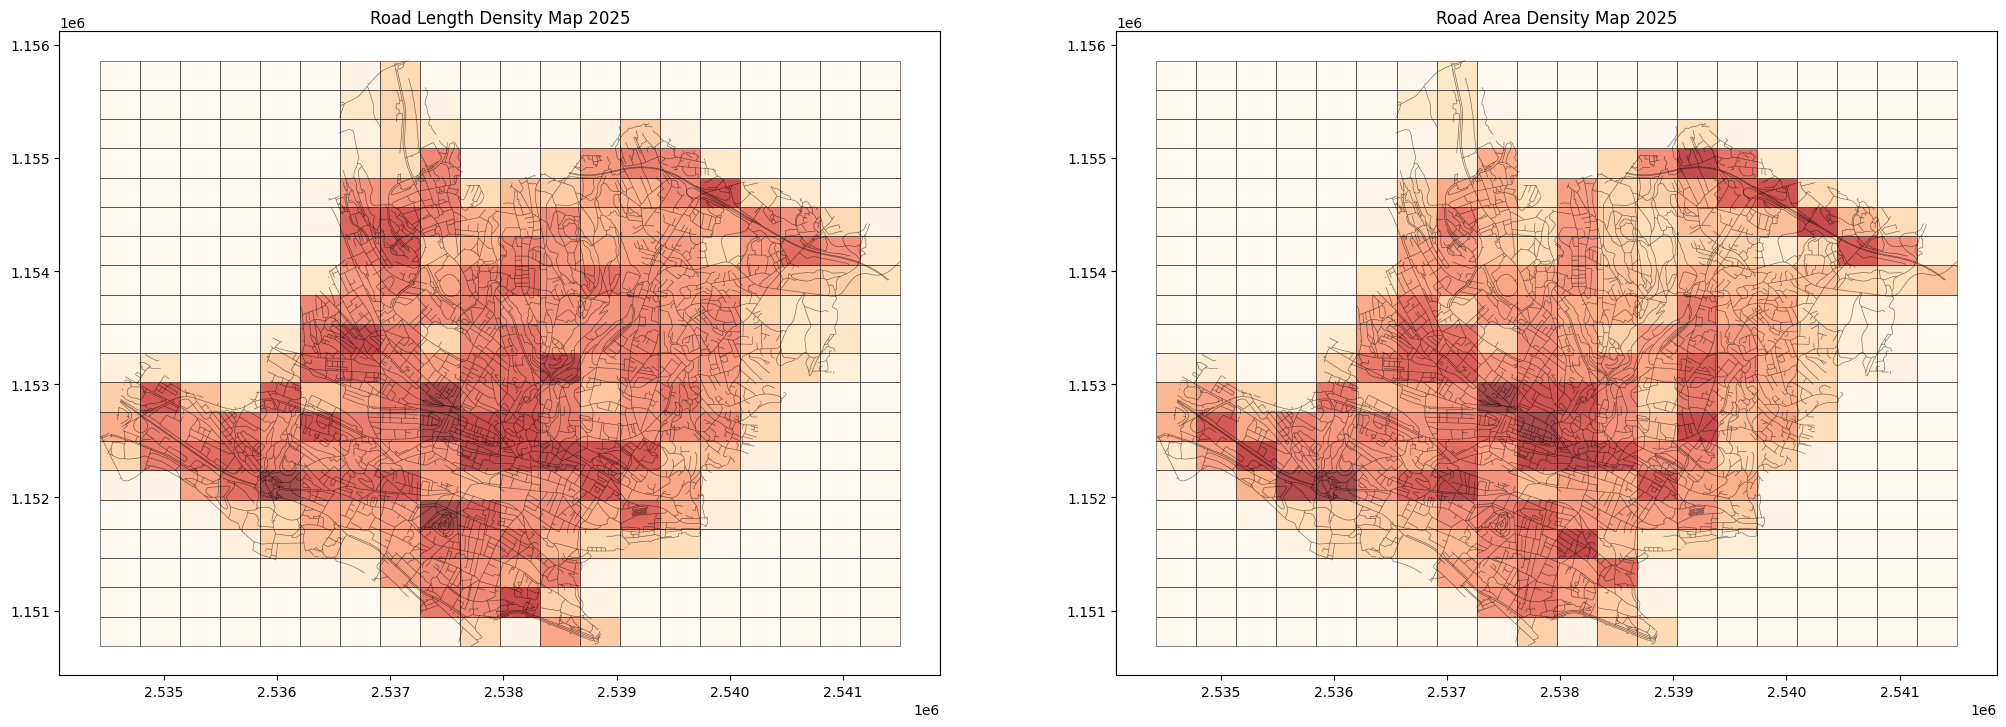

In [39]:
# Example usage
geojson_path = "roads_2025_parties.geojson"  # Replace with your file path
n_patches = 20
roads_gdf = load_roads(geojson_path)

# P: Platz -> mean
# A: Autobahn -> max
# E: Einfahrt -> 3
# D: Dienstzufahrt -> mean

density_gdf = compute_road_density_map(roads_gdf, roads_gdf.total_bounds, n_patches)
plot_density_map(density_gdf, roads_gdf, 2025)

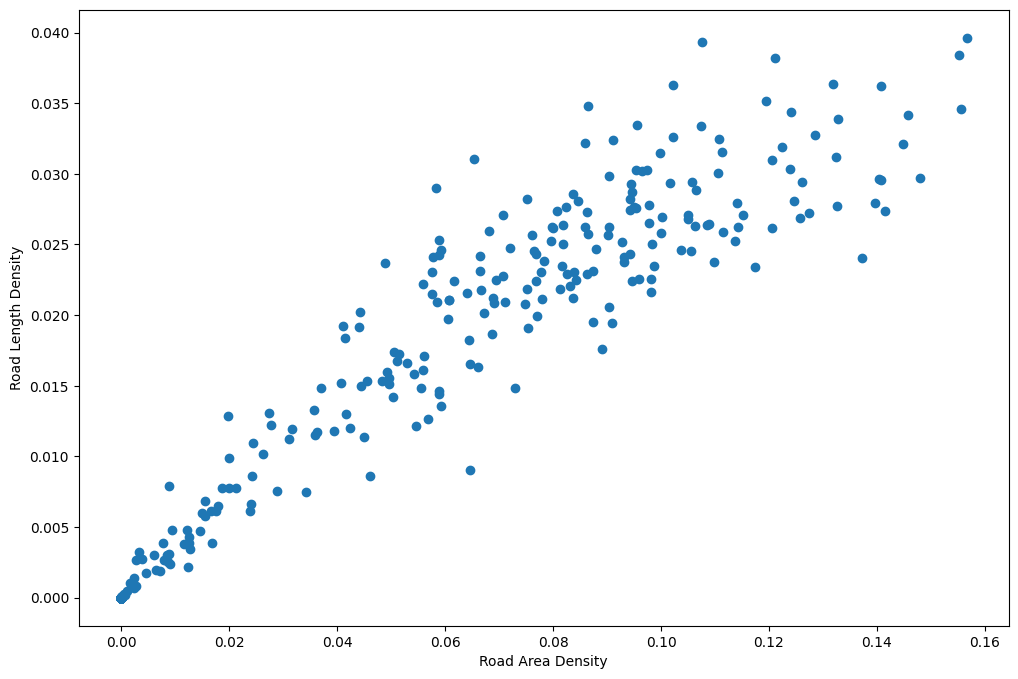

In [12]:
plt.figure(figsize=(12,8))
plt.scatter(density_gdf.road_density_area, density_gdf.road_density_length)
plt.xlabel("Road Area Density")
plt.ylabel("Road Length Density")
plt.show()

In [14]:
correlation = density_gdf["road_density_area"].corr(density_gdf["road_density_length"])
print(f"The Pearson correlation between Road Area Density and Road Length Density is {correlation}")

The Pearson correlation between Road Area Density and Road Length Density is 0.9624956215073139


## 1975 to 2025

In [19]:
geojson_path_1_4_1975 = "roads_1_4_1975.geojson"
gdf_1_4 = gpd.read_file(geojson_path_1_4_1975)

geojson_path_2_6_1975 = "roads_2_6_1975.geojson"
gdf_2_6 = gpd.read_file(geojson_path_2_6_1975)

geojson_path_3_5_1975 = "roads_3_5_1975.geojson"
gdf_3_5 = gpd.read_file(geojson_path_3_5_1975)

geojson_path = "roads_2025_parties.geojson"
roads_2025_gdf = gpd.read_file(geojson_path)

roads_1975_gdf = pd.concat([gdf_2_6[gdf_2_6.PARTIE == 2],gdf_2_6[gdf_2_6.PARTIE == 6],gdf_1_4[gdf_1_4.PARTIE == 4],gdf_1_4[gdf_1_4.PARTIE == 1],gdf_3_5[gdf_3_5.PARTIE == 3],gdf_3_5[gdf_3_5.PARTIE == 5]],axis=0)

In [20]:
n_patches = 30

minx_2025, miny_2025, maxx_2025, maxy_2025 = roads_2025_gdf.total_bounds
minx_1975, miny_1975, maxx_1975, maxy_1975 = roads_1975_gdf.total_bounds

minx = min(minx_1975, minx_2025)
miny = min(miny_1975, miny_2025)
maxx = max(maxx_1975, maxx_2025)
maxy = max(maxy_1975, maxy_2025)

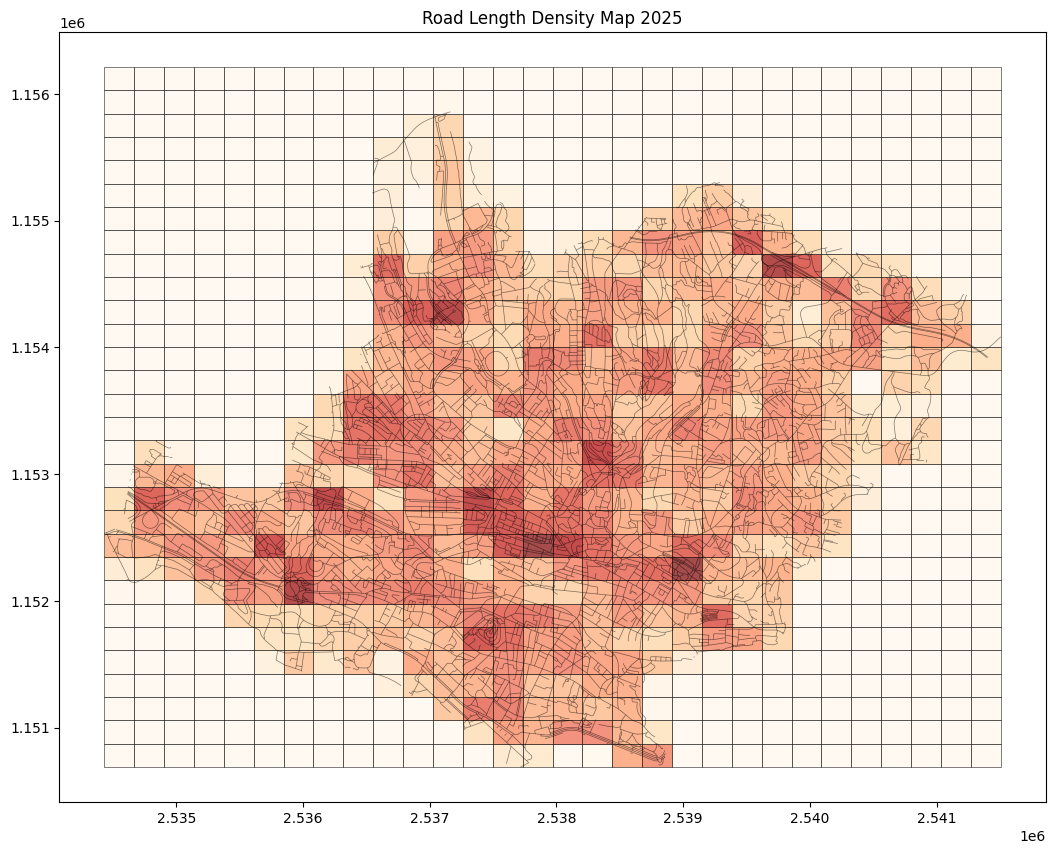

In [21]:
density_2025_gdf = compute_road_density_map(roads_2025_gdf, (minx, miny, maxx, maxy), n_patches)
plot_density_map(density_2025_gdf, roads_2025_gdf, 2025)

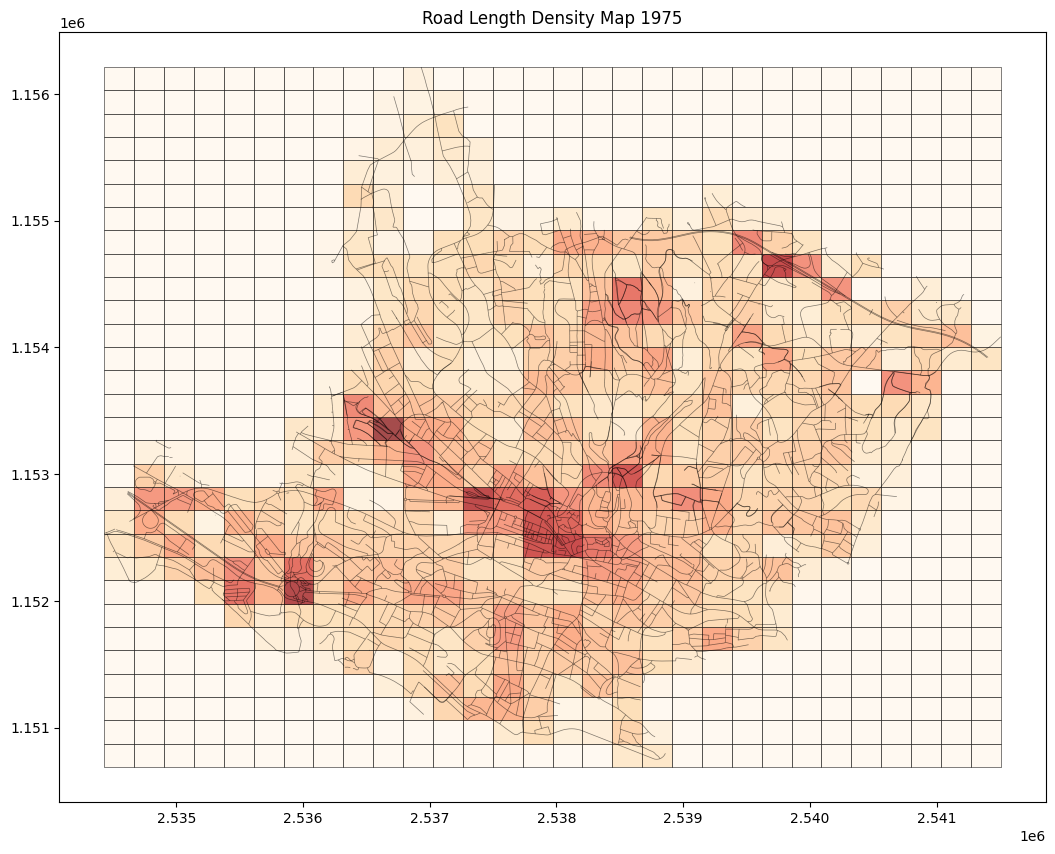

In [22]:
density_1975_gdf = compute_road_density_map(roads_1975_gdf, (minx, miny, maxx, maxy), n_patches)
plot_density_map(density_1975_gdf, roads_1975_gdf, 1975)

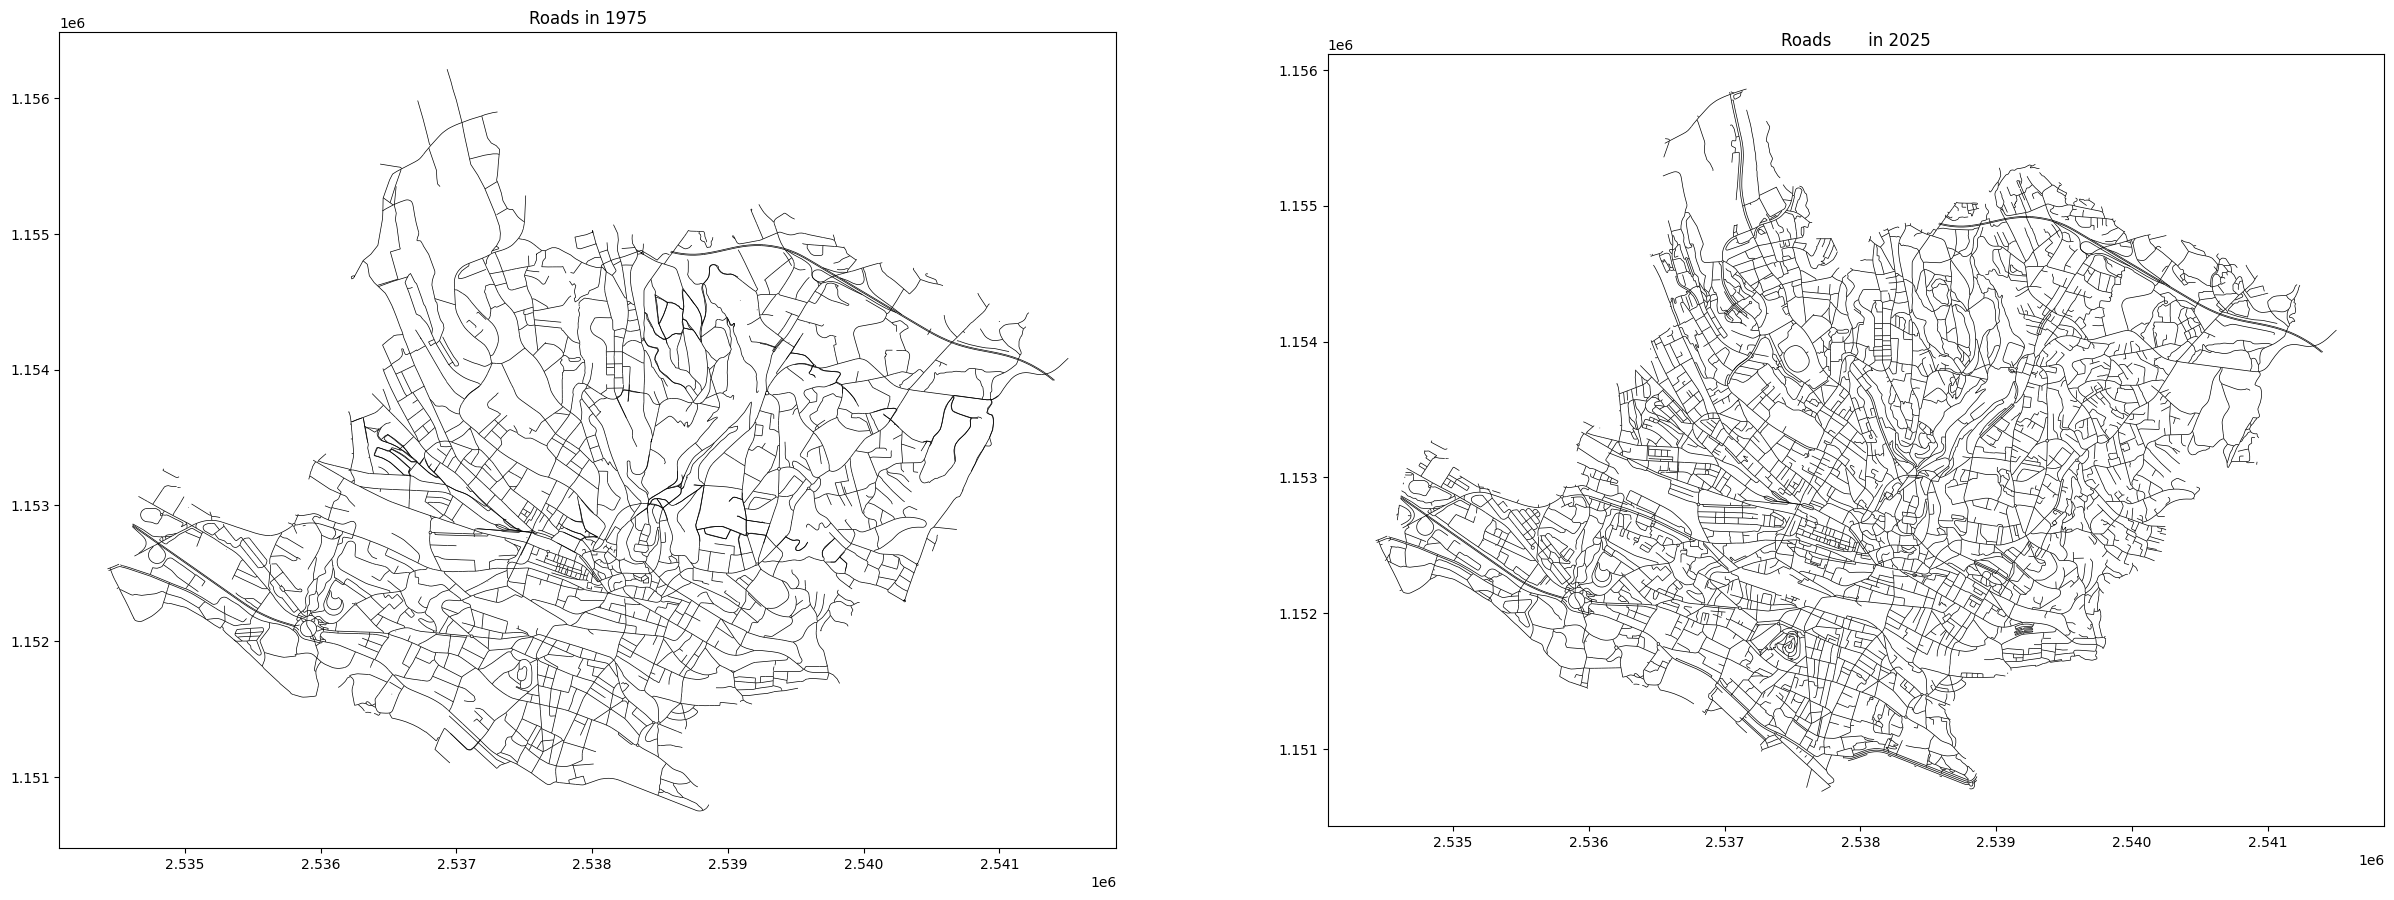

In [23]:
fig, ax = plt.subplots(1,2,figsize=(30, 20))

vmin = 0
vmax = max(density_1975_gdf.road_density_length.max(),density_2025_gdf.road_density_length.max())

#density_1975_gdf.plot(column="road_density_length", cmap="OrRd", linewidth=0.5, edgecolor="black", alpha=0.7, legend=False, ax=ax[0], vmin=vmin, vmax=vmax)
roads_1975_gdf.plot(color="black", linewidth=0.5, alpha=1, ax=ax[0])
ax[0].set_title("Roads in 1975")

#density_2025_gdf.plot(column="road_density_length", cmap="OrRd", linewidth=0.5, edgecolor="black", alpha=0.7, legend=False, ax=ax[1], vmin=vmin, vmax=vmax)
roads_2025_gdf.plot(color="black", linewidth=0.5, alpha=1, ax=ax[1])
ax[1].set_title("Roads       in 2025")

plt.show()

In [24]:
gdf_comparison = density_2025_gdf.merge(density_1975_gdf, how="inner", on="geometry", suffixes=["","_1975"])
gdf_comparison["1975_to_2025_incr"] = gdf_comparison["road_density_length"] - gdf_comparison["road_density_length_1975"]

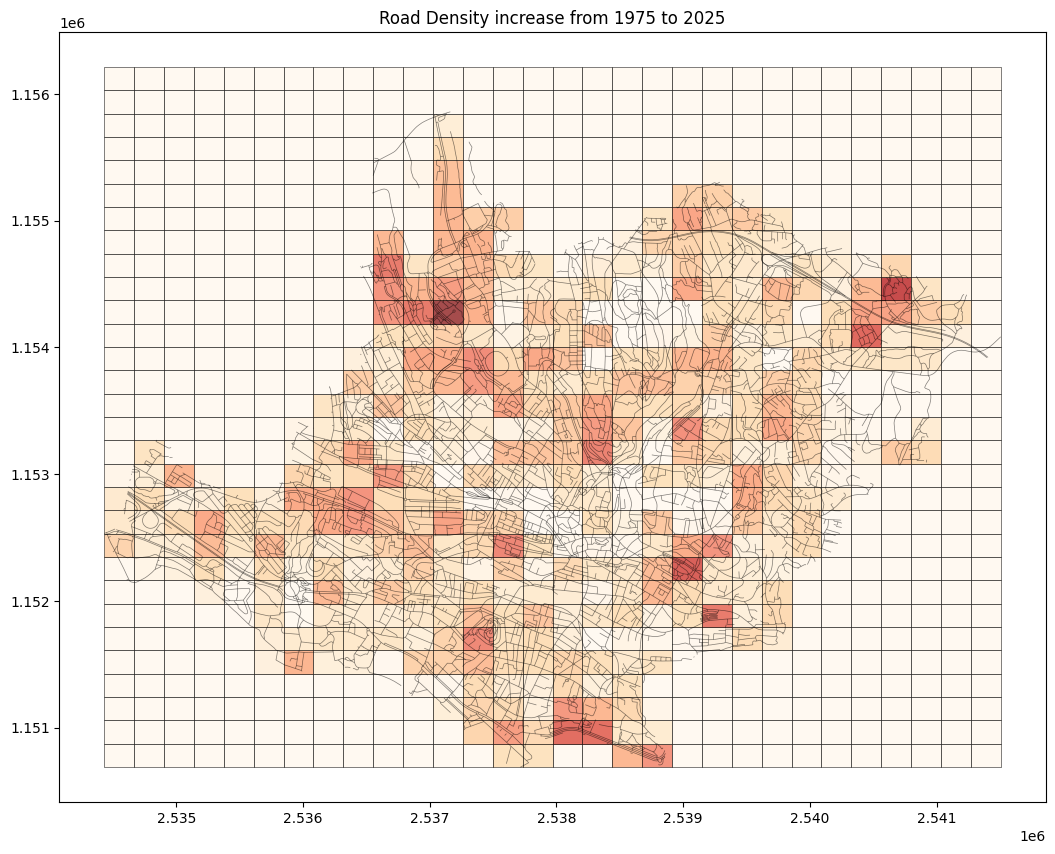

In [25]:
fig, ax = plt.subplots(1,1,figsize=(15, 10))

vmin = 0
vmax = gdf_comparison["1975_to_2025_incr"].max()

gdf_comparison.plot(column="1975_to_2025_incr", cmap="OrRd", linewidth=0.5, edgecolor="black", alpha=0.7, legend=False, ax=ax, vmin=vmin, vmax=vmax)
roads_2025_gdf.plot(color="black", linewidth=0.5, alpha=0.5, ax=ax)
ax.set_title("Road Density increase from 1975 to 2025")

plt.show()